## Setup

We begin by importing our dependencies.

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import time
from random import random

Set our seed and other configurations for reproducibility.

In [22]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
PATH = './netWithNoise.pth'

## Dataset

We load the datasets using the `torchvision` package. 

In [23]:
from model import *
from data import *
from pre_processing import *

Wait for both datasets to be downloaded and verified.
Files already downloaded and verified
Files already downloaded and verified
Examples:


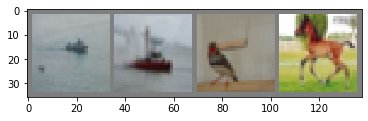

In [24]:
batch_size = 1024 * 4
dataset = Loader(batch_size=batch_size)
trainloader = dataset.trainloader

def examples(trainloader):
    # get some random training images
    dataiter = iter(trainloader)
    images, _ = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images[:4]))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


print('Examples:')
examples(trainloader)

# Training
Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate an `AE` object.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [9]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
net = AE().to(device)
print('Network:', net)

net.batchSize(batch_size)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

Network: AE(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
  (latent): Linear(in_features=12800, out_features=10, bias=True)
  (latent2): Linear(in_features=10, out_features=12800, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
)


We train our autoencoder for our specified number of epochs.

In [10]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""
def accuracy(true,pred):
    # calculate distance pixelwise
    dist = torch.abs(pred.cpu() - true.cpu()).float().detach().numpy()
    return 100 - 100 * dist.sum() / np.prod(true.shape)

def transformTensor(tensor, epoch):
    return tensor
    # dont add noise for the first 30 epochs
    if epoch < 30:
        return tensor
    # add noise
    images = tensor.detach().data.numpy()
    noise_images = add_gaussian_noise(images, 0, 0.0003 * epoch)
    tensor = torch.from_numpy(noise_images)
    return tensor.to(device, dtype=torch.float)

print("start training")

def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    start_time = time.time()
    acc = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        accuracy_epoch = []
        for data in trainloader:
            img, _ = data
            img = transformTensor(img, epoch).to(device)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            accuracy_epoch.append(accuracy(img, outputs))
            
        lossEp = running_loss / len(trainloader)
        train_loss.append(lossEp)
        avgAcc = np.average(accuracy_epoch)
        acc.append(avgAcc)
        timePerEpoch = (time.time() - start_time)/(epoch + 1)
        left = timePerEpoch * (NUM_EPOCHS - epoch + 1)
        print('Epoch {} of {}, Train Loss: {:.3f} Accuracy: {:.3f}'.format(epoch+1, NUM_EPOCHS, lossEp, avgAcc), ' aprox. ' + str(round(left / 60)) + ' min left')
 
    print('Finished Training')
    elapsed_time = time.time() - start_time
    print('final duration: ' + str(round(elapsed_time / 60)) + 'min')
    return train_loss, acc

train_loss, train_acc = train(net, dataset.trainloader, 120)
torch.save(net.state_dict(), PATH) 

start training
Epoch 1 of 120, Train Loss: 0.257 Accuracy: 57.549  aprox. 33 min left
Epoch 2 of 120, Train Loss: 0.254 Accuracy: 57.801  aprox. 32 min left
Epoch 3 of 120, Train Loss: 0.250 Accuracy: 58.160  aprox. 31 min left
Epoch 4 of 120, Train Loss: 0.239 Accuracy: 59.303  aprox. 30 min left
Epoch 5 of 120, Train Loss: 0.224 Accuracy: 61.067  aprox. 30 min left
Epoch 6 of 120, Train Loss: 0.206 Accuracy: 63.035  aprox. 29 min left
Epoch 7 of 120, Train Loss: 0.197 Accuracy: 64.094  aprox. 29 min left
Epoch 8 of 120, Train Loss: 0.191 Accuracy: 64.779  aprox. 29 min left
Epoch 9 of 120, Train Loss: 0.188 Accuracy: 65.191  aprox. 28 min left
Epoch 10 of 120, Train Loss: 0.185 Accuracy: 65.532  aprox. 28 min left
Epoch 11 of 120, Train Loss: 0.185 Accuracy: 65.654  aprox. 28 min left
Epoch 12 of 120, Train Loss: 0.183 Accuracy: 65.838  aprox. 28 min left
Epoch 13 of 120, Train Loss: 0.183 Accuracy: 65.930  aprox. 27 min left
Epoch 14 of 120, Train Loss: 0.182 Accuracy: 66.012  aprox

NameError: name 'train_loss' is not defined

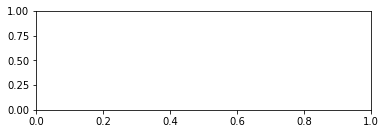

In [13]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""

fig, ax = plt.subplots()
# ax.plot(train_loss, label='loss')
# ax.plot(acc, label='accuracy')
# ax.set(xlabel='epoch')
# ax.grid()
# ax.legend()
# plt.draw()

plt.subplot(2, 1, 1)
plt.plot(train_loss)
plt.title('Training')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.show()

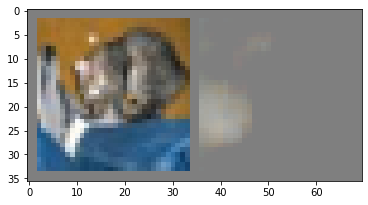

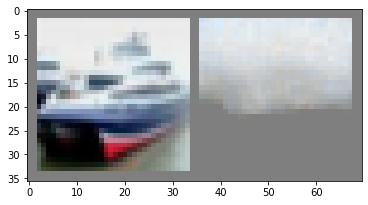

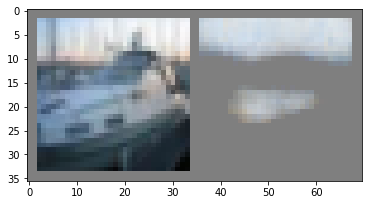

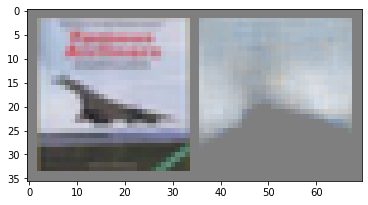

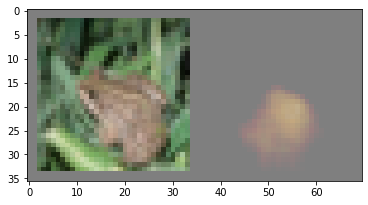

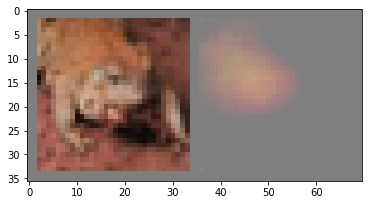

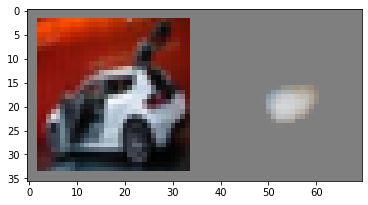

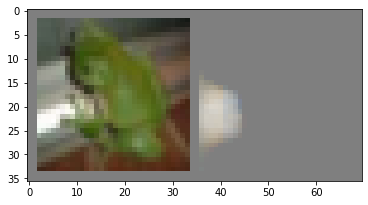

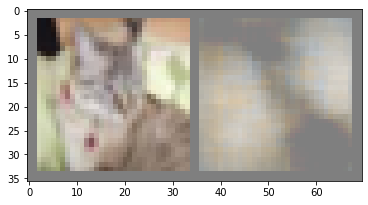

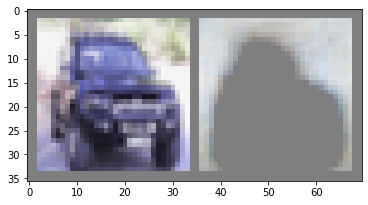

In [25]:
from eval import *
# load test set
dataset_iter = iter(dataset.testloader)
images, classes = dataset_iter.next()
length = len(images)
classNames = dataset.classes

# load network
net2 = AE()
net2.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

# show reconstructed images
outputs = net2(images[:10])

for i in range(10):
    imshow(torchvision.utils.make_grid([images[i], outputs[i]]).detach())


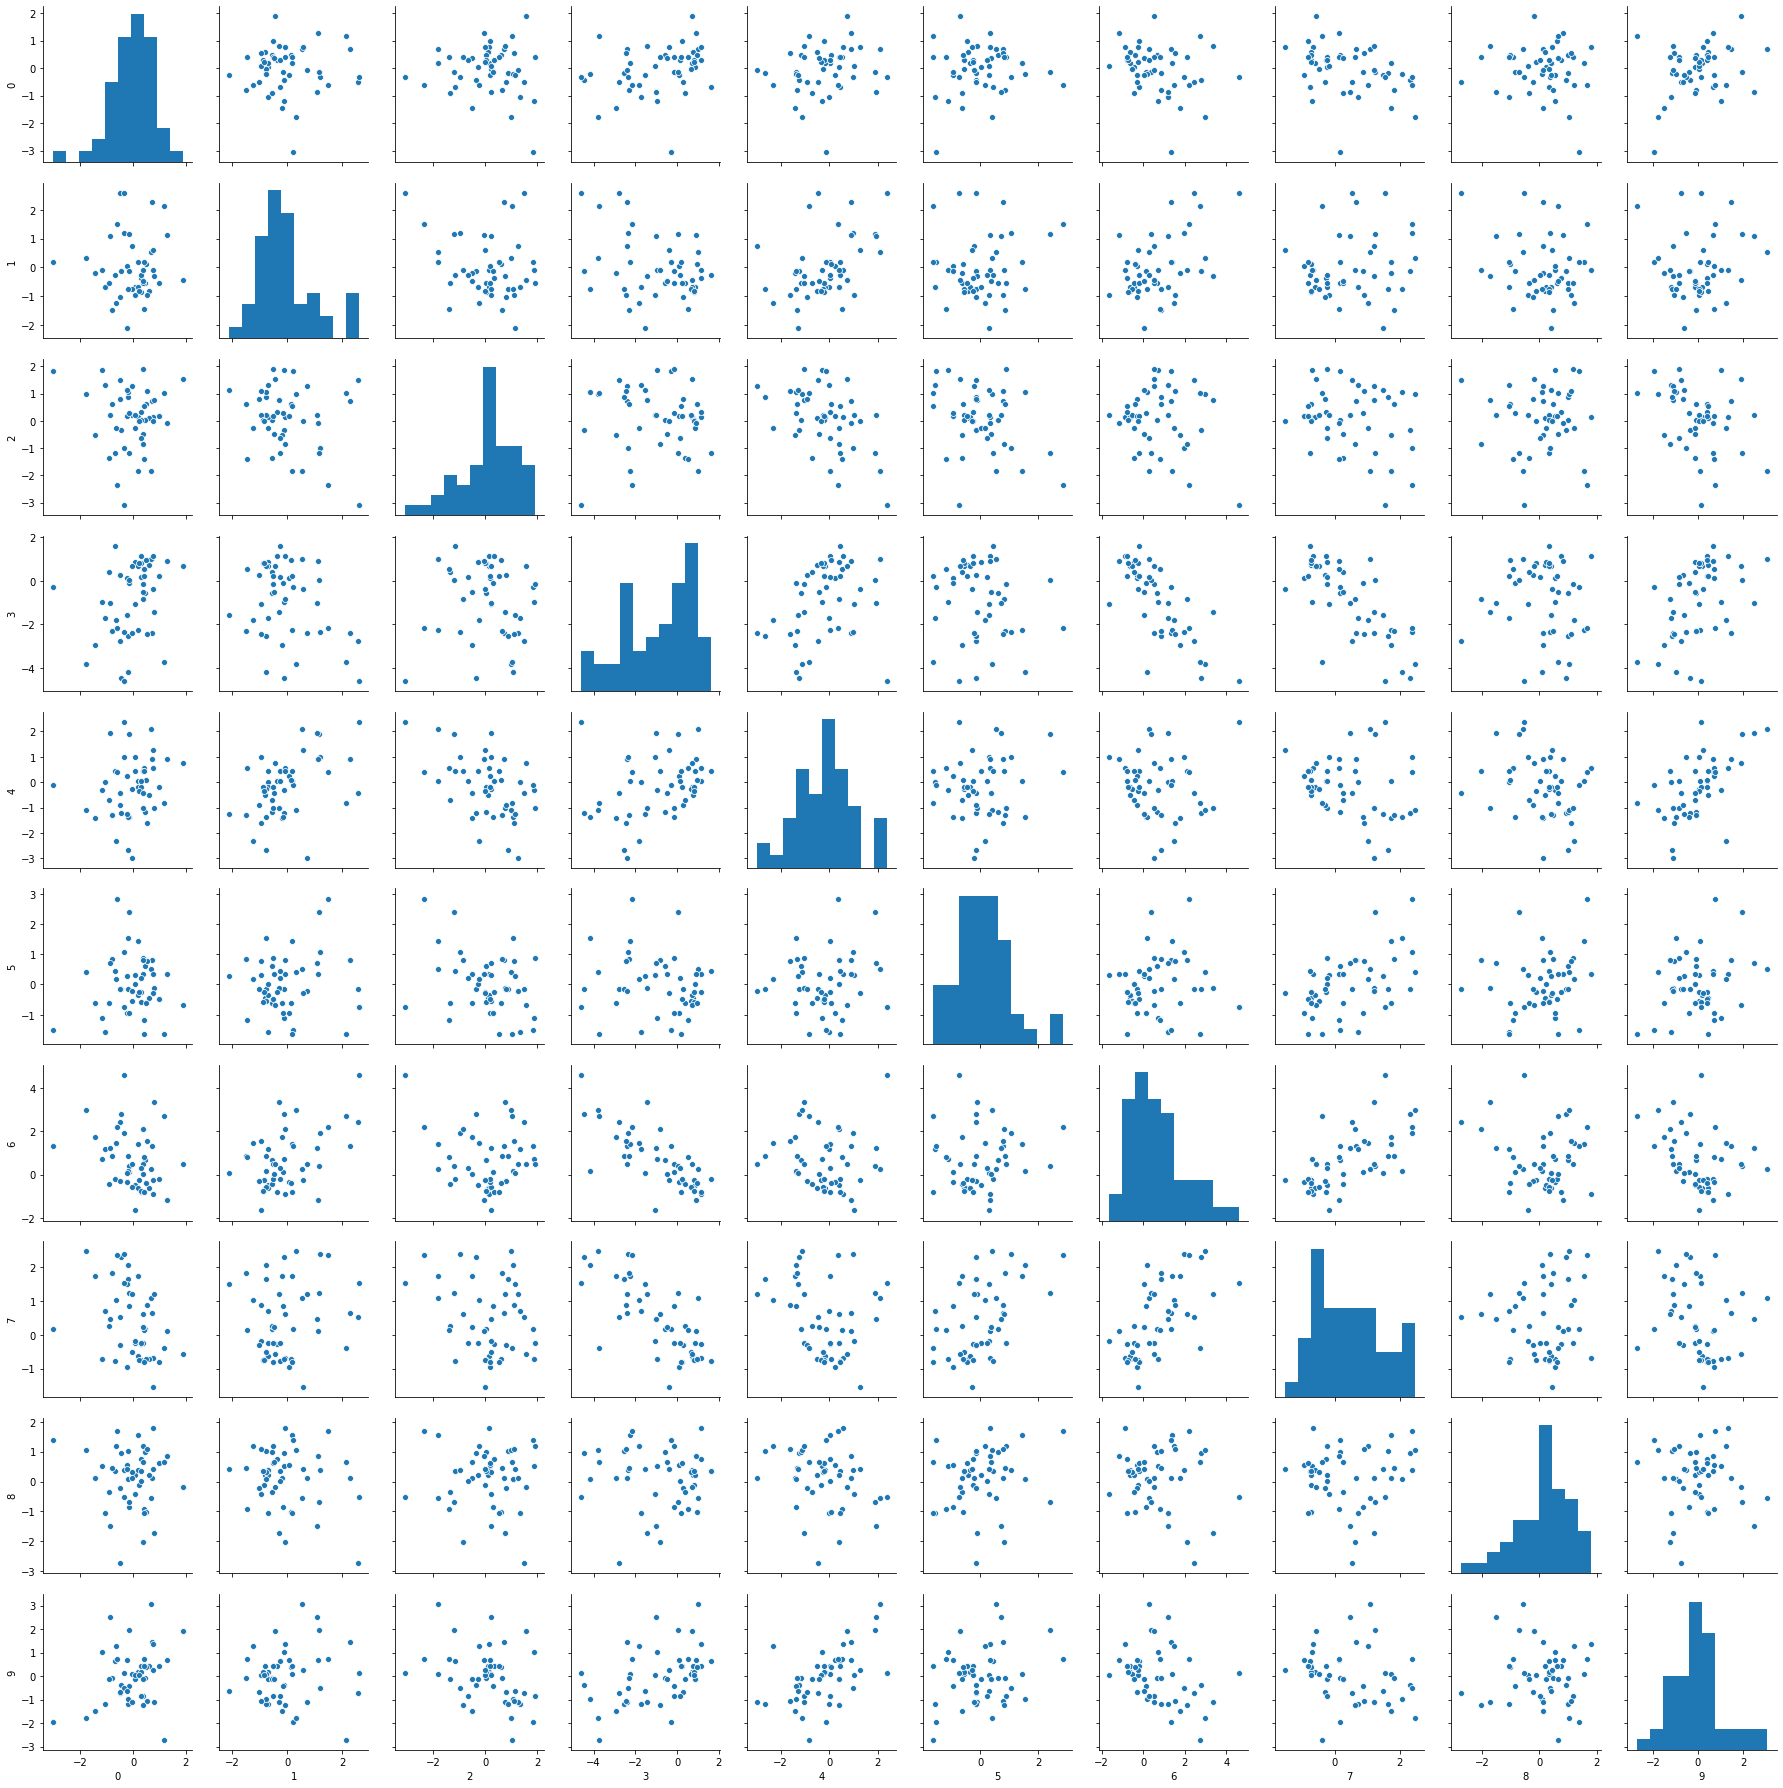

In [26]:
#pairplot

dataset_iter = iter(dataset.testloader)
images, classes = dataset_iter.next()
length = len(images)

net2 = AE()
net2.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

net2.getLatentSpace(True)

outputs = net2(images).data.numpy()

outputFrame = pd.DataFrame(outputs)

sns.pairplot(outputFrame.sample(50))




In [14]:
#umap

import umap

umapObj = umap.UMAP().fit(outputs)
fit.shape                                                        
umap.plot.points(umapObj, labels=classes)



ModuleNotFoundError: No module named 'umap'

In [27]:
# model should output latent space and not reconstruction
net2.getLatentSpace(True)

# process images
outputs = net2(images).data.numpy()
outputShape = np.shape(outputs)

# flatten latent space
outputs = outputs.flatten().reshape(length, np.prod(outputShape[1:]))
classNames = dataset.classes




1: truck


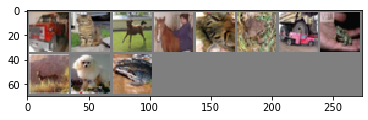

closest: cat: 2,   deer: 1,   dog: 1,   frog: 3,   horse: 2,   truck: 2,    (accuracy: 1/10)


2: plane


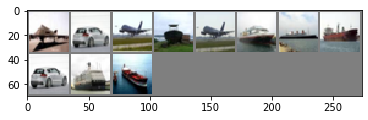

closest: car: 2,   plane: 3,   ship: 6,    (accuracy: 2/10)


3: ship


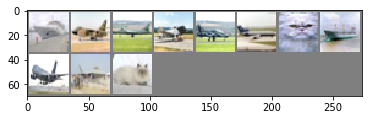

closest: cat: 2,   plane: 7,   ship: 2,    (accuracy: 1/10)


4: dog


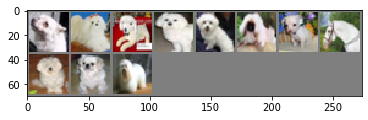

closest: dog: 10,   horse: 1,    (accuracy: 9/10)


5: car


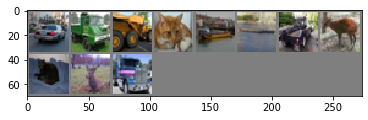

closest: car: 1,   cat: 2,   deer: 2,   ship: 2,   truck: 4,    (accuracy: 0/10)


6: bird


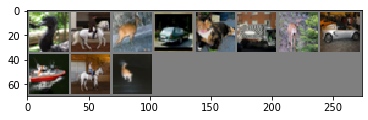

closest: bird: 1,   car: 2,   cat: 2,   deer: 2,   horse: 2,   ship: 1,   truck: 1,    (accuracy: 0/10)


7: cat


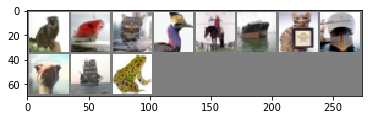

closest: bird: 2,   cat: 3,   frog: 1,   horse: 1,   ship: 4,    (accuracy: 2/10)


8: frog


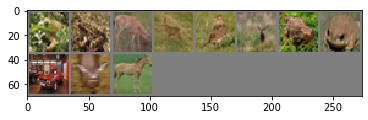

closest: bird: 1,   car: 1,   deer: 4,   frog: 4,   horse: 1,    (accuracy: 3/10)


9: car


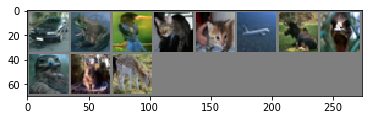

closest: bird: 3,   car: 1,   cat: 3,   deer: 2,   frog: 1,   plane: 1,    (accuracy: 0/10)


10: cat


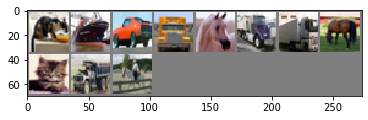

closest: car: 1,   cat: 2,   horse: 3,   ship: 1,   truck: 4,    (accuracy: 1/10)


11: deer


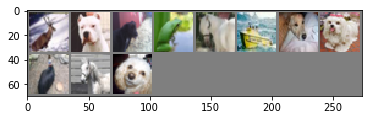

closest: bird: 1,   deer: 1,   dog: 5,   frog: 1,   horse: 2,   ship: 1,    (accuracy: 0/10)


12: horse


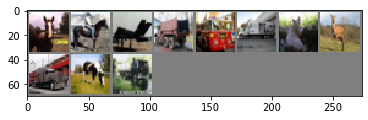

closest: cat: 1,   deer: 1,   horse: 3,   plane: 1,   truck: 5,    (accuracy: 2/10)


13: car


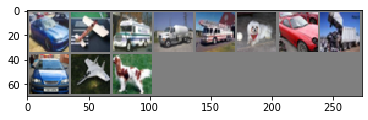

closest: car: 3,   dog: 2,   plane: 2,   truck: 4,    (accuracy: 2/10)


14: horse


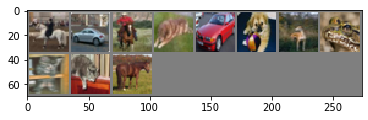

closest: car: 2,   cat: 2,   deer: 1,   dog: 2,   frog: 1,   horse: 3,    (accuracy: 2/10)


15: deer


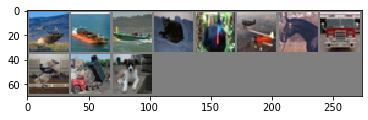

closest: bird: 1,   cat: 1,   deer: 1,   dog: 1,   horse: 2,   plane: 1,   ship: 2,   truck: 2,    (accuracy: 0/10)


16: truck


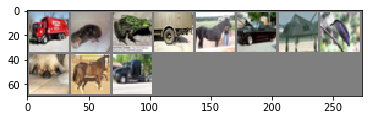

closest: bird: 1,   car: 1,   cat: 1,   dog: 1,   frog: 1,   horse: 2,   plane: 1,   truck: 3,    (accuracy: 2/10)


17: cat


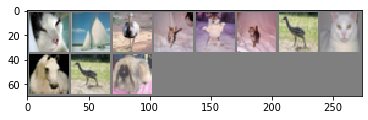

closest: bird: 3,   cat: 4,   dog: 2,   horse: 1,   ship: 1,    (accuracy: 3/10)


18: truck


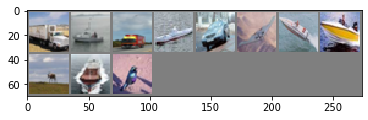

closest: bird: 1,   car: 1,   deer: 1,   plane: 1,   ship: 5,   truck: 2,    (accuracy: 1/10)


19: car


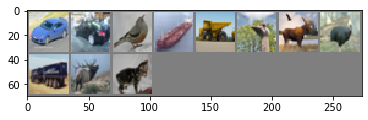

closest: bird: 3,   car: 2,   cat: 1,   deer: 2,   ship: 1,   truck: 2,    (accuracy: 1/10)


20: cat


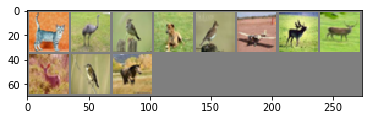

closest: bird: 4,   cat: 1,   deer: 3,   dog: 1,   horse: 1,   plane: 1,    (accuracy: 0/10)


In [28]:
# get 20 random images with closest matches
for i in range(20):
    print('\n')
    srcImgId = round(random() * length)
    srcImgClass = classes[srcImgId]
    closest = findNClosest(outputs[srcImgId], outputs, 11)

    acc = 0
    closeImages = []
    closeClasses = []
    for img in closest:
        id = int(img[-1])
        closeImages.append(images[id])
        closeClasses.append(classNames[classes[id]])
        acc += 1 if classes[id] == srcImgClass else 0
    
    # show images
    print(str(i + 1) + ": " + classNames[srcImgClass])
    imshow(torchvision.utils.make_grid(closeImages))

    # show classes
    unique, count = np.unique(closeClasses, return_counts = True) 
    res = ""
    for j in range(len(unique)):
        res += unique[j] + ": " + str(count[j]) + ",   "
    
    print('closest: ' + res + ' (accuracy: ' + str(acc - 1) + '/10)')